# TO DO 
- [ ] reshape output of Ncopies bums
- [ ] add to MF Model
- [ ] make the same for GM models

In [1]:
import nifty8 as ift
import nifty8.re as jft
from jax import random
import jax.numpy as jnp
import numpy as np
import jax
from functools import reduce

In [2]:
from nifty8.re.tree_math import ShapeWithDtype

In [3]:
seed = 42
key = random.PRNGKey(seed)
key, subkey = random.split(key)

e_dims = (10)
s_dims = (128,128)

In [4]:
cf_zm = {"offset_mean": 0., "offset_std": (1e-3, 1e-4)}
cf_fl = {
    "fluctuations": (1e-1, 5e-3),
    "loglogavgslope": (-1., 1e-2),
    "flexibility": (1e+0, 5e-1),
    "asperity": (5e-1, 5e-2),
    "harmonic_type": "Fourier"
}
cfm = jft.CorrelatedFieldMaker("space_cf")
cfm.set_amplitude_total_offset(**cf_zm)
cfm.add_fluctuations(
    s_dims,
    distances=1. / s_dims[0],
    **cf_fl,
    prefix="ax1",
    non_parametric_kind="power"
)
correlated_field = cfm.finalize()

In [5]:
correlated_field.target

ShapeDtypeStruct(shape=(128, 128), dtype=float64)

In [6]:
dev_zm = {"offset_mean": 0., "offset_std": (1e-3, 1e-4)}
dev_fl = {
    "fluctuations": (1e-1, 5e-3),
    "loglogavgslope": (-1., 1e-2),
    "flexibility": (1e+0, 5e-1),
    "asperity": (5e-1, 5e-2),
    "harmonic_type": "Fourier"}
dev_cfm = jft.CorrelatedFieldMaker("dev_cf")
dev_cfm.set_amplitude_total_offset(**cf_zm)
dev_cfm.add_fluctuations(
    e_dims,
    distances=1. / e_dims,
    **cf_fl,
    prefix="ax1",
    non_parametric_kind="power"
)
dev_correlated_field = dev_cfm.finalize()

In [17]:
prefix = "dev_cf"

In [18]:
class NCopiesCorrField():
    def __init__(self, cf, N_copies, prefix):
        """
        Parameters:
        ----------
        N_copies: Tuple of int,
                Shape of the new field, implicitely defining the Number of copies. 
                Each of the correlated fields has the same power spectrum,
                but different excitations.
        cf: Correlated Field Model,
            from nifty.re

        returns:
        -------
        Model for multiple CorrelatedFields with the same pspec 
        but different xi_s.     
        """
        self.cf = cf
        self.N_copies = N_copies
        self.number = reduce(lambda x, y: x * y, self.N_copies)
        self.xi_key = prefix+ "xi"
        self.n_xis = cf.domain[self.xi_key].size
        self.target_flatten = ShapeWithDtype(shape=(self.n_xis, self.number))
        self.target = ShapeWithDtype(shape=((self.n_xis,) + self.N_copies))
        self.new_domain = self._extend_xi_domain()
        
    def _partly_apply_cf(self, pos_init):
        def partly(xi, xi_key):
            pos_init.tree.pop(xi_key)
            pos_init.tree.update({xi_key: xi})
            return self.cf(pos_init)
        return partly
        
    def _extend_xi_domain(self):
        dict = self.cf.domain.copy()
        dict.update({self.xi_key: self.target_flatten})
        return dict

    def partial_init_ncopies_model(self, pos_new):
        func = self._partly_apply_cf(pos_new)
        ncopies_model_func = jax.vmap(func, in_axes=(1, None), out_axes=1)
        res = ncopies_model_func(pos_new.tree[self.xi_key], self.xi_key)
        return res.reshape(self.cf.target.shape + self.N_copies)

    def build_model(self):       
        return jft.Model(self.partial_init_ncopies_model,
                         domain=self.new_domain,
                         target=self.target)
    

In [19]:
n_copies_model = NCopiesCorrField(dev_correlated_field, s_dims, prefix)

In [20]:
n_copies_model.number

16384

In [21]:
cf_split = n_copies_model.build_model()

In [22]:
pos_init = jft.Vector(jft.random_like(subkey, cf_split.domain))

In [23]:
bla = cf_split(pos_init)

In [24]:
bla.shape

(10, 128, 128)

In [25]:
pos_init.tree

{'dev_cfax1asperity': Array(-1.13534265, dtype=float64),
 'dev_cfax1flexibility': Array(2.4272829, dtype=float64),
 'dev_cfax1fluctuations': Array(1.57093463, dtype=float64),
 'dev_cfax1loglogavgslope': Array(0.28920913, dtype=float64),
 'dev_cfax1spectrum': Array([[ 1.28747917,  1.37864512],
        [ 0.02729241, -1.71109745],
        [-0.43035809,  0.2405074 ],
        [ 0.08757448,  0.53687717]], dtype=float64),
 'dev_cfzeromode': Array(0.44715392, dtype=float64),
 'dev_cfxi': Traced<ShapedArray(float64[10])>with<BatchTrace(level=1/0)> with
   val = Array([[ 0.1902152 ,  1.06774771, -0.6889996 , ..., -0.01896687,
         -1.13394635,  0.29860208],
        [-0.49351879,  0.14603658, -0.26626583, ...,  0.26404124,
         -0.7409112 , -0.42939249],
        [-0.91541344,  0.45502445,  0.62019567, ...,  1.9841436 ,
          0.1367123 , -1.72876267],
        ...,
        [-1.51743895,  1.30425849,  0.19456975, ..., -0.12777923,
         -0.5982305 ,  1.50892976],
        [-0.31955328,

In [26]:
alpha_zm = {"offset_mean": 0., "offset_std": (1e-3, 1e-4)}
alpha_fl = {
    "fluctuations": (1e-1, 5e-3),
    "loglogavgslope": (-1., 1e-2),
    "flexibility": (1e+0, 5e-1),
    "asperity": (5e-1, 5e-2),
    "harmonic_type": "Fourier"
}
alpha = jft.CorrelatedFieldMaker("alpha")
alpha.set_amplitude_total_offset(**alpha_zm)
alpha.add_fluctuations(
    s_dims,
    distances=1. / s_dims[0],
    **alpha_fl,
    prefix="ax1",
    non_parametric_kind="power"
)
alpha_field = alpha.finalize()

In [27]:
freqs = jnp.arange(-2,10)
#freqs = jnp.array([1,3,4,7,12,17,19.3])

In [28]:
dims_freq = freqs.shape
dev_zm = {"offset_mean": 0., "offset_std": (1e-3, 1e-4)}
dev_fl = {
    "fluctuations": (1e-1, 5e-3),
    "loglogavgslope": (-1., 1e-2),
    "flexibility": (1e+0, 5e-1),
    "asperity": (5e-1, 5e-2),
    "harmonic_type": "Fourier"
}
dev = jft.CorrelatedFieldMaker("dev")
dev.set_amplitude_total_offset(**dev_zm)
dev.add_fluctuations(
    dims_freq,
    distances=1. /dims_freq[0],
    **dev_fl,
    prefix="ax1",
    non_parametric_kind="power"
)
dev_field = dev.finalize()

In [29]:
key, subkey = random.split(key)
pos_init = jft.Vector(jft.random_like(subkey, dev_field.domain))
freq_dev = dev_field(pos_init)

In [30]:
dev = jft.WienerProcess((0, 1), (1, 3), 2, name="margret", N_steps= 10)

In [31]:
dev.domain

{'margret': ShapeWithDtype(shape=(10,), dtype=<class 'jax.numpy.float64'>),
 'margret_x0': ShapeWithDtype(shape=(), dtype=<class 'jax.numpy.float64'>),
 'margret_sigma': ShapeWithDtype(shape=(), dtype=<class 'jax.numpy.float64'>)}

key, subkey = random.split(key)
pos_init = jft.Vector(jft.random_like(subkey, dev.domain))
dev(pos_init).shape

In [32]:
def mf_model(freqs, alph, spatial, dev):
    print(type(alph))
    if isinstance(alph, jft.Model):
        plaw = lambda x: jnp.outer(freqs, alph(x)).reshape(freqs.shape + alph.target.shape)
        plaw_offset = lambda x: plaw(x) + spatial(x)
        res = lambda x: plaw_offset(x) + dev(x)
        domain = alph.domain | spatial.domain | dev.domain
        res = jft.Model(res, domain=domain)
    elif isinstance(alph, float):
        res = jnp.outer(freqs, alph).reshape(freqs.shape)
    return res

In [33]:
cf_split.domain

{'dev_cfzeromode': ShapeWithDtype(shape=(), dtype=<class 'jax.numpy.float64'>),
 'dev_cfax1fluctuations': ShapeWithDtype(shape=(), dtype=<class 'jax.numpy.float64'>),
 'dev_cfax1loglogavgslope': ShapeWithDtype(shape=(), dtype=<class 'jax.numpy.float64'>),
 'dev_cfax1spectrum': ShapeWithDtype(shape=(4, 2), dtype=<class 'jax.numpy.float64'>),
 'dev_cfax1flexibility': ShapeWithDtype(shape=(), dtype=<class 'jax.numpy.float64'>),
 'dev_cfax1asperity': ShapeWithDtype(shape=(), dtype=<class 'jax.numpy.float64'>),
 'dev_cfxi': ShapeWithDtype(shape=(10, 16384), dtype=<class 'jax.numpy.float64'>)}

In [34]:
correlated_field.domain

{'space_cfzeromode': ShapeWithDtype(shape=(), dtype=<class 'jax.numpy.float64'>),
 'space_cfax1fluctuations': ShapeWithDtype(shape=(), dtype=<class 'jax.numpy.float64'>),
 'space_cfax1loglogavgslope': ShapeWithDtype(shape=(), dtype=<class 'jax.numpy.float64'>),
 'space_cfax1spectrum': ShapeWithDtype(shape=(1619, 2), dtype=<class 'jax.numpy.float64'>),
 'space_cfax1flexibility': ShapeWithDtype(shape=(), dtype=<class 'jax.numpy.float64'>),
 'space_cfax1asperity': ShapeWithDtype(shape=(), dtype=<class 'jax.numpy.float64'>),
 'space_cfxi': ShapeWithDtype(shape=(128, 128), dtype=<class 'jax.numpy.float64'>)}

In [35]:
new_model = mf_model(freqs, alpha_field, correlated_field, cf_split)
#scalar_model = outer_product(freqs, 5.)


<class 'nifty8.re.model.Model'>


AttributeError: 'dict' object has no attribute 'tree'

In [118]:
new_model

Model(
	<function mf_model.<locals>.<lambda> at 0x7f7ee4685120>,
	domain={'alphaax1asperity': ShapeWithDtype(shape=(), dtype=<class 'jax.numpy.float64'>),
	 'alphaax1flexibility': ShapeWithDtype(shape=(), dtype=<class 'jax.numpy.float64'>),
	 'alphaax1fluctuations': ShapeWithDtype(shape=(), dtype=<class 'jax.numpy.float64'>),
	 'alphaax1loglogavgslope': ShapeWithDtype(shape=(), dtype=<class 'jax.numpy.float64'>),
	 'alphaax1spectrum': ShapeWithDtype(shape=(1619, 2), dtype=<class 'jax.numpy.float64'>),
	 'alphaxi': ShapeWithDtype(shape=(128, 128), dtype=<class 'jax.numpy.float64'>),
	 'alphazeromode': ShapeWithDtype(shape=(), dtype=<class 'jax.numpy.float64'>),
	 'cfax1asperity': ShapeWithDtype(shape=(), dtype=<class 'jax.numpy.float64'>),
	 'cfax1flexibility': ShapeWithDtype(shape=(), dtype=<class 'jax.numpy.float64'>),
	 'cfax1fluctuations': ShapeWithDtype(shape=(), dtype=<class 'jax.numpy.float64'>),
	 'cfax1loglogavgslope': ShapeWithDtype(shape=(), dtype=<class 'jax.numpy.float64'>)

In [117]:
cf_split

Model(
	<bound method NCopiesCorrField.partial_init_ncopies_model of <__main__.NCopiesCorrField object at 0x7f7e8556bc40>>,
	domain={'cfax1asperity': ShapeWithDtype(shape=(), dtype=<class 'jax.numpy.float64'>),
	 'cfax1flexibility': ShapeWithDtype(shape=(), dtype=<class 'jax.numpy.float64'>),
	 'cfax1fluctuations': ShapeWithDtype(shape=(), dtype=<class 'jax.numpy.float64'>),
	 'cfax1loglogavgslope': ShapeWithDtype(shape=(), dtype=<class 'jax.numpy.float64'>),
	 'cfax1spectrum': ShapeWithDtype(shape=(4, 2), dtype=<class 'jax.numpy.float64'>),
	 'cfxi': ShapeWithDtype(shape=(10, 16384), dtype=<class 'jax.numpy.float64'>),
	 'cfzeromode': ShapeWithDtype(shape=(), dtype=<class 'jax.numpy.float64'>)},
	init=<class 'nifty8.re.model.NoValue'>
)

In [38]:
#scalar_model.shape

In [39]:
jft.Gaussian

nifty8.re.likelihood_impl.Gaussian

In [40]:
key, subkey = random.split(key)
pos_init = jft.Vector(jft.random_like(subkey, new_model.domain))

In [41]:
field = new_model(pos_init)

In [42]:
import matplotlib.pyplot as plt

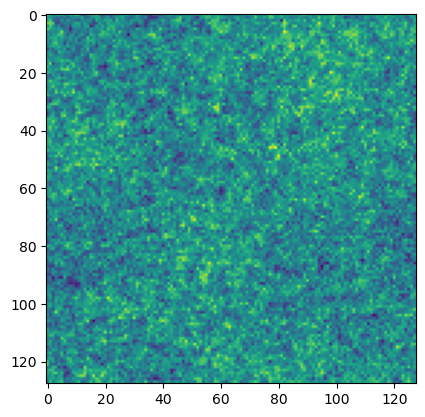

In [43]:
blub = alpha_field(pos_init)
plt.imshow(blub)

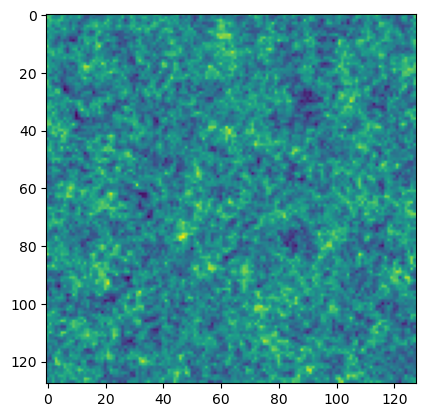

In [44]:
peng = correlated_field(pos_init)
plt.imshow(peng)

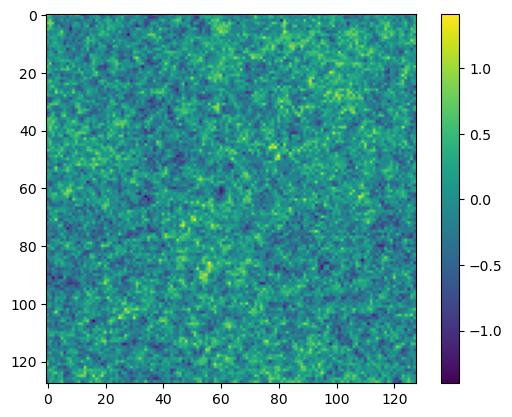

In [45]:
plt.imshow(field[6])
plt.colorbar()

In [46]:
peng[0,0] # spatial
blub[0,0] # alpha

Array(0.18441817, dtype=float64)

In [47]:
xs = np.linspace(-2,6)
fxs = blub[0,0]*xs + peng[0,0]

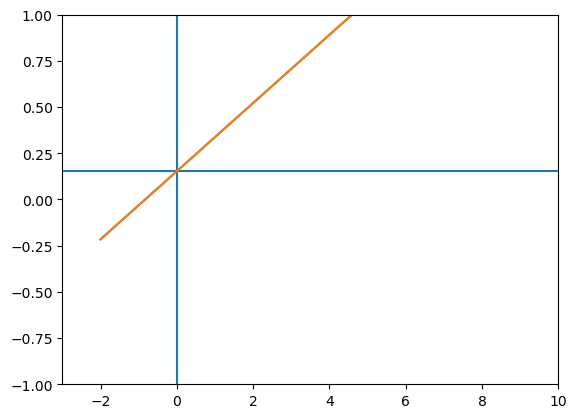

In [48]:
plt.plot(freqs, field[:,0,0])
plt.xlim(-3,10)
plt.ylim(-1,1)
plt.axvline(0,-1,1)
plt.axhline(peng[0,0], -1, 1)
plt.plot(xs, fxs)

In [49]:
correlated_field(pos_init).shape

(128, 128)

In [50]:
class MFSky(jft.Model()):
    def __init__(spatial, alphas, deviations=None):
        self._spatial = spatial
        self._alphas = alphas

    def _model(self):
        res = jnp.outer()
        return res

ValueError: one of `init` or `domain` must be set

In [44]:
import nifty8 as ift

# How it was on nifty

In [48]:
sp1 = ift.RGSpace([10])
cfmaker = ift.CorrelatedFieldMaker('', total_N=100)
cfmaker.add_fluctuations(sp1, (0.1, 1e-2), (2, .2), (.01, .5), (-4, 2.),
                             'amp1')
cfmaker.set_amplitude_total_offset(0., (1e-2, 1e-6))
correlated_field = cfmaker.finalize()

Offset amplitude: 1.00E-02 ± 1.02E-06
Offset amplitude: 1.00E-02 ± 1.02E-06
Offset amplitude: 1.00E-02 ± 1.02E-06
Offset amplitude: 1.00E-02 ± 1.02E-06
Offset amplitude: 1.00E-02 ± 1.02E-06
Offset amplitude: 1.00E-02 ± 1.02E-06
Offset amplitude: 1.00E-02 ± 1.02E-06
Offset amplitude: 1.00E-02 ± 1.02E-06
Offset amplitude: 1.00E-02 ± 1.02E-06
Offset amplitude: 1.00E-02 ± 1.02E-06
Offset amplitude: 1.00E-02 ± 1.02E-06
Offset amplitude: 1.00E-02 ± 1.02E-06
Offset amplitude: 1.00E-02 ± 1.02E-06
Offset amplitude: 1.00E-02 ± 1.02E-06
Offset amplitude: 1.00E-02 ± 1.02E-06
Offset amplitude: 1.00E-02 ± 1.02E-06
Offset amplitude: 1.00E-02 ± 1.02E-06
Offset amplitude: 1.00E-02 ± 1.02E-06
Offset amplitude: 1.00E-02 ± 1.02E-06
Offset amplitude: 1.00E-02 ± 1.02E-06
Offset amplitude: 1.00E-02 ± 1.02E-06
Offset amplitude: 1.00E-02 ± 1.02E-06
Offset amplitude: 1.00E-02 ± 1.02E-06
Offset amplitude: 1.00E-02 ± 1.02E-06
Offset amplitude: 1.00E-02 ± 1.02E-06
Offset amplitude: 1.00E-02 ± 1.02E-06
Offset ampli

# Philipps Kot

In [51]:
import nifty8.re as jft
import jax
from functools import partial

In [52]:
dims = (128, 128)
cf_zm = dict(offset_mean=0., offset_std=(1e-3, 1e-4))
cf_fl=dict(fluctuations=(1e-1, 5e-3),
           loglogavgslope=(-1., 1e-2),
           flexibility=(1e+0, 5e-1),
           asperity=(5e-1, 5e-2),
           )
cfm=jft.CorrelatedFieldMaker("cf")
cfm.set_amplitude_total_offset(**cf_zm)
cfm.add_fluctuations(
    dims,
    distances=1. /dims[0],
    **cf_fl,
    prefix="ax1",
    non_parametric_kind="power"
    )
correlated_field=cfm.finalize()

In [88]:
class MappedModel(jft.Model):
    def __init__(self, correlated_field, cf_prefix, ndof):
        """
        Parameters:
        ----------
        correlated_field : CF Model
        cf_prefix: probably string ?
        ndof: number of copies
        """
        keys = correlated_field.domain.keys()
        xi_key = cf_prefix+'xi'
        if xi_key not in keys:
            raise ValueError
        xi_dom = correlated_field.domain[xi_key]
        xiinit = partial(jft.random_like,
                         primals= jft.ShapeWithDtype((ndof,) +xi_dom.shape, xi_dom.dtype)
                        )
        init = correlated_field.init
        init = {k: init[k] if k != xi_key else xiinit for k in keys}
        self._cf = correlated_field
        self._axs=({k: 0 if k==xi_key else None for k in keys},)
        super().__init__(init=jft.Initializer(init))

    def __call__(self, x):
        return jax.vmap(self._cf, in_axes = self._axs, out_axes=0)(x)
        
my_cf = MappedModel(correlated_field, 'cf', 5) 

In [90]:
from jax import random

seed = 42
key = random.PRNGKey(seed)
key, subkey = random.split(key)
pos_init = jft.Vector(jft.random_like(subkey, my_cf.domain))

In [83]:
pos_init.tree['cfxi'].shape

(5, 128, 128)

In [84]:
my_cf(pos_init.tree)

Array([[[ 0.11494462,  0.05645465,  0.11532231, ..., -0.04879707,
         -0.03003488,  0.05308657],
        [-0.0353079 , -0.03589519, -0.01881053, ...,  0.05159067,
         -0.07721204, -0.06718515],
        [-0.10538343, -0.0412607 ,  0.07495413, ...,  0.05629424,
         -0.12121512, -0.19235673],
        ...,
        [-0.04132943, -0.0266047 ,  0.02882559, ..., -0.12080258,
          0.00640089, -0.06814372],
        [ 0.07042061,  0.13890535,  0.10933648, ...,  0.07286666,
          0.04512115,  0.23127944],
        [-0.05473494,  0.26502994,  0.19499038, ..., -0.11339462,
         -0.19631791,  0.06046597]],

       [[ 0.08428521,  0.04124434, -0.09943837, ...,  0.14713904,
          0.12781259,  0.01218086],
        [-0.12172331, -0.05866076, -0.12065003, ...,  0.14315622,
          0.02596044,  0.13020823],
        [-0.05458745, -0.1772966 , -0.08852383, ...,  0.10451993,
          0.1218762 ,  0.05429754],
        ...,
        [ 0.09456729,  0.02794557,  0.13907814, ...,  

In [85]:
pos_init

Vector(
	{'cfax1asperity': Array(-1.13534265, dtype=float64),
	 'cfax1flexibility': Array(2.4272829, dtype=float64),
	 'cfax1fluctuations': Array(1.57093463, dtype=float64),
	 'cfax1loglogavgslope': Array(0.28920913, dtype=float64),
	 'cfax1spectrum': Array([[-1.15184846, -1.81177194],
	       [ 0.22924416,  1.34274164],
	       [ 0.48104256,  1.12632326],
	       ...,
	       [-0.68132783,  0.51603301],
	       [ 0.29714618, -2.63223404],
	       [-0.72753759,  0.17951879]], dtype=float64),
	 'cfxi': Array([[[ 2.18100817e+00,  1.49957683e+00,  6.19436361e-01, ...,
	          6.48867118e-01,  9.30692268e-01, -6.30126890e-01],
	        [-3.95765324e-01,  5.59403417e-01,  8.47862144e-01, ...,
	          1.29992523e+00, -1.30543648e-01,  8.91520925e-01],
	        [ 1.72066741e+00, -3.68714812e-01, -1.32184078e+00, ...,
	          2.95607751e-01, -1.48280973e+00,  2.84247983e-01],
	        ...,
	        [-1.83082422e+00,  1.65015513e+00, -2.00941606e+00, ...,
	          1.31332849e-01,  1.

In [12]:
my_cf._axs

({'cfzeromode': None,
  'cfax1fluctuations': None,
  'cfax1loglogavgslope': None,
  'cfax1spectrum': None,
  'cfax1flexibility': None,
  'cfax1asperity': None,
  'cfxi': 0},)

In [70]:
seed = 42
key = random.PRNGKey(seed)
key, subkey = random.split(key)
pos_init = jft.Vector(jft.random_like(subkey, correlated_field.domain))


Model(
	<function CorrelatedFieldMaker.finalize.<locals>.correlated_field at 0x7f9ae8757910>,
	domain={'cfax1asperity': ShapeWithDtype(shape=(), dtype=<class 'jax.numpy.float64'>),
	 'cfax1flexibility': ShapeWithDtype(shape=(), dtype=<class 'jax.numpy.float64'>),
	 'cfax1fluctuations': ShapeWithDtype(shape=(), dtype=<class 'jax.numpy.float64'>),
	 'cfax1loglogavgslope': ShapeWithDtype(shape=(), dtype=<class 'jax.numpy.float64'>),
	 'cfax1spectrum': ShapeWithDtype(shape=(1619, 2), dtype=<class 'jax.numpy.float64'>),
	 'cfxi': ShapeWithDtype(shape=(128, 128), dtype=<class 'jax.numpy.float64'>),
	 'cfzeromode': ShapeWithDtype(shape=(), dtype=<class 'jax.numpy.float64'>)},
	init=Initializer(
		{'cfax1asperity': functools.partial(<function random_like at 0x7f9b6c4452d0>, primals=ShapeWithDtype(shape=(), dtype=<class 'jax.numpy.float64'>)),
		 'cfax1flexibility': functools.partial(<function random_like at 0x7f9b6c4452d0>, primals=ShapeWithDtype(shape=(), dtype=<class 'jax.numpy.float64'>)),


In [72]:
correlated_field(pos_init.tree)

Array([[-0.20371447, -0.1509742 ,  0.00944695, ..., -0.04446404,
         0.01625982, -0.07620315],
       [ 0.11485683,  0.18729345, -0.00211782, ...,  0.03029136,
        -0.05823543, -0.14138227],
       [-0.15006994, -0.02584387,  0.01427238, ..., -0.04191982,
         0.05150019,  0.06370812],
       ...,
       [ 0.03852824,  0.07820086,  0.14331601, ..., -0.09857849,
         0.19053673, -0.01884422],
       [ 0.1144397 , -0.02239834,  0.18909805, ..., -0.12947804,
        -0.07628902, -0.03692135],
       [ 0.11539612,  0.23447825,  0.22160249, ...,  0.09467593,
        -0.04181763, -0.1253474 ]], dtype=float64)